In [1]:
from argparse import Namespace
import time
import sys
import pprint
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms
import os
import pathlib
import matplotlib.pyplot as plt

sys.path.append(".")
sys.path.append("..")

from datasets import augmentations
from utils.common import tensor2im, log_input_image
from models.psp import pSp

%load_ext autoreload
%autoreload 2

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-s3s7w12o because the default path (/home/uadmin/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## Step 1: Select Experiment Type

In [2]:
#@title Select which experiment you wish to perform inference on: { run: "auto" }
experiment_type = 'ffhq_encode' #@param ['ffhq_encode', 'ffhq_frontalize', 'celebs_sketch_to_face', 'celebs_seg_to_face', 'celebs_super_resolution', 'toonify']

## Step 2: Download Pretrained Models 
As part of this repository, we provide pretrained models for each of the above experiments. We'll download the model for the selected experiments as save it to the folder `../pretrained_models`.

In [3]:
def get_download_model_command(file_id, file_name):
    """ Get wget download command for downloading the desired model and save to directory ../pretrained_models. """
    current_directory = os.getcwd()
    save_path = os.path.join(os.path.dirname(current_directory), 'pixel2style2pixel', "pretrained_models")
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    url = r"""wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id={FILE_ID}' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id={FILE_ID}" -O {SAVE_PATH}/{FILE_NAME} && rm -rf /tmp/cookies.txt""".format(FILE_ID=file_id, FILE_NAME=file_name, SAVE_PATH=save_path)
    return url

In [4]:
MODEL_PATHS = {
    "ffhq_encode": {"id": "1bMTNWkh5LArlaWSc_wa8VKyq2V42T2z0", "name": "psp_ffhq_encode.pt"},
    "ffhq_frontalize": {"id": "1_S4THAzXb-97DbpXmanjHtXRyKxqjARv", "name": "psp_ffhq_frontalization.pt"},
    "celebs_sketch_to_face": {"id": "1lB7wk7MwtdxL-LL4Z_T76DuCfk00aSXA", "name": "psp_celebs_sketch_to_face.pt"},
    "celebs_seg_to_face": {"id": "1VpEKc6E6yG3xhYuZ0cq8D2_1CbT0Dstz", "name": "psp_celebs_seg_to_face.pt"},
    "celebs_super_resolution": {"id": "1ZpmSXBpJ9pFEov6-jjQstAlfYbkebECu", "name": "psp_celebs_super_resolution.pt"},
    "toonify": {"id": "1YKoiVuFaqdvzDP5CZaqa3k5phL-VDmyz", "name": "psp_ffhq_toonify.pt"}
}

path = MODEL_PATHS[experiment_type]
download_command = get_download_model_command(file_id=path["id"], file_name=path["name"])

In [5]:
#!wget {download_command}

## Step 3: Define Inference Parameters

Below we have a dictionary defining parameters such as the path to the pretrained model to use and the path to the image to perform inference on.  
While we provide default values to run this script, feel free to change as needed.

In [6]:
EXPERIMENT_DATA_ARGS = {
    "ffhq_encode": {
        "model_path": "pretrained_models/psp_ffhq_encode.pt",
        "image_path": "test_imgs",
        "transform": transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    },
    "celebs_super_resolution": {
        "model_path": "pretrained_models/psp_celebs_super_resolution.pt",
        "image_path": "notebooks/images/input_img.jpg",
        "transform": transforms.Compose([
            transforms.Resize((256, 256)),
            augmentations.BilinearResize(factors=[16]),
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    }
}

In [7]:
EXPERIMENT_ARGS = EXPERIMENT_DATA_ARGS[experiment_type]

In [8]:
vector_folder = 'directions'

In [9]:
def shift_target_vector(self, target, shift_dict: dict):
    for i in range(target.shape[0]):
        if len(shift_dict) > 0:
            for vector_key in shift_dict: 
                target[i, ...] += shift_dict[vector_key] * self.vector_spaces[vector_key].float()
    return target

In [10]:
vector_spaces = {vector[:-4]: torch.tensor(np.load(os.path.join(os.getcwd(), vector_folder, vector))).to('cuda') for vector in os.listdir(vector_folder)}

In [11]:
print(vector_spaces.keys())

dict_keys(['gender', 'age'])


We need to verify that the model was downloaded correctly. All of our models should weigh approximately 1.12GB.  
Note that if the file weighs several KBs, you most likely encounter a "quota exceeded" error from Google Drive. In that case, you should try downloading the model again after a few hours.

In [12]:
if os.path.getsize(EXPERIMENT_ARGS['model_path']) < 1000000:
  raise ValueError("Pretrained model was unable to be downlaoded correctly!")

## Step 4: Load Pretrained Model
We assume that you have downloaded all relevant models and placed them in the directory defined by the above dictionary.

In [13]:
model_path = EXPERIMENT_ARGS['model_path']
ckpt = torch.load(model_path, map_location='cuda')

In [14]:
opts = ckpt['opts']
pprint.pprint(opts)

{'batch_size': 8,
 'board_interval': 50,
 'checkpoint_path': None,
 'dataset_type': 'ffhq_encode',
 'device': 'cuda:0',
 'encoder_type': 'GradualStyleEncoder',
 'exp_dir': '',
 'id_lambda': 0.1,
 'image_interval': 100,
 'input_nc': 3,
 'l2_lambda': 1.0,
 'l2_lambda_crop': 0,
 'label_nc': 0,
 'learn_in_w': False,
 'learning_rate': 0.0001,
 'lpips_lambda': 0.8,
 'lpips_lambda_crop': 0,
 'max_steps': 300000,
 'optim_name': 'ranger',
 'resize_factors': None,
 'save_interval': 1000,
 'start_from_latent_avg': True,
 'stylegan_weights': '',
 'test_batch_size': 8,
 'test_workers': 2,
 'train_decoder': False,
 'val_interval': 2500,
 'w_norm_lambda': 0,
 'workers': 8}


In [15]:
# update the training options
opts['checkpoint_path'] = model_path
if 'learn_in_w' not in opts:
    opts['learn_in_w'] = False

In [16]:
opts = Namespace(**opts)
net = pSp(opts)
net.eval()
net.cuda()
print('Model successfully loaded!')

Loading pSp from checkpoint: pretrained_models/psp_ffhq_encode.pt
Model successfully loaded!


## Step 5: Visualize Input

In [17]:
test_pics = {}
for image in os.listdir(EXPERIMENT_DATA_ARGS[experiment_type]["image_path"]):
    test_pics[image] = Image.open(os.path.join(EXPERIMENT_DATA_ARGS[experiment_type]["image_path"], image))

In [18]:
test_pics

{'pexels-rodrigo-feksa-5626159.jpg': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3461x5191 at 0x7F00C64E4FA0>,
 'pexels-francesca-zama-6386956.jpg': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=4000x6000 at 0x7F00C6434070>,
 'pexels-simon-robben-614810.jpg': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=4684x4000 at 0x7F00C64340D0>,
 'pexels-katerina-holmes-5905497.jpg': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=4000x6000 at 0x7F00C6434160>}

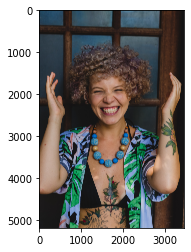

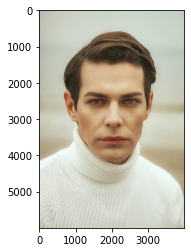

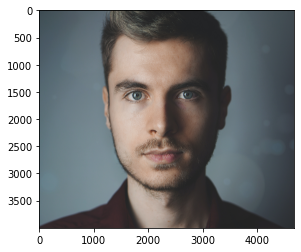

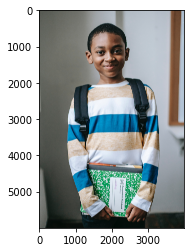

In [36]:
for name in test_pics:
    plt.figure()
    plt.imshow(test_pics[name])

### Align Image

Note: in this notebook we'll run alignment on the input image for all tasks except for `celebs_sketch_to_face` and `celebs_seg_to_face`. That is, only for tasks with real images as inputs.
However, all of our applications assume the input has been pre-aligned!

In [20]:
# !wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
# !bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2

In [21]:
def run_alignment(image_path):
  import dlib
  from scripts.align_all_parallel import align_face
  predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
  aligned_image = align_face(filepath=image_path, predictor=predictor)
  print("Aligned image has shape: {}".format(aligned_image.size))
  return aligned_image

In [42]:
test_img_paths = []
for name in os.listdir(EXPERIMENT_DATA_ARGS[experiment_type]["image_path"]):
    test_img_paths.append(os.path.join(EXPERIMENT_DATA_ARGS[experiment_type]["image_path"], name))

In [44]:
aligned_images = {}
for img in test_img_paths:
    print(img)
    aligned_images[img] = run_alignment(img)

test_imgs/pexels-rodrigo-feksa-5626159.jpg
Aligned image has shape: (256, 256)
test_imgs/pexels-francesca-zama-6386956.jpg
Aligned image has shape: (256, 256)
test_imgs/pexels-simon-robben-614810.jpg
Aligned image has shape: (256, 256)
test_imgs/pexels-katerina-holmes-5905497.jpg
Aligned image has shape: (256, 256)


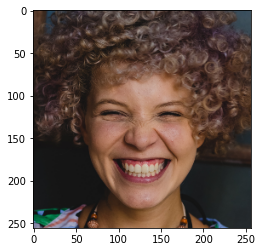

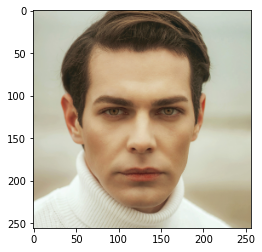

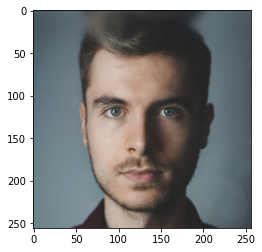

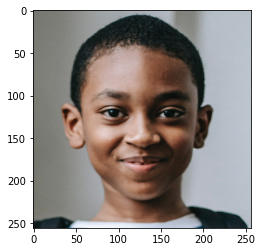

In [45]:
%matplotlib inline
for name in aligned_images:
    plt.figure()
    plt.imshow(aligned_images[name])

## Step 6: Perform Inference

In [53]:
output_images = []
img_transforms = EXPERIMENT_ARGS['transform']
for input_image in aligned_images:
    transformed_image = img_transforms(aligned_images[input_image])
    res = net(transformed_image.unsqueeze(0).to("cuda:0").float(), vector_shift={'gender': -3, 'age': 5}, vector_spaces=vector_spaces)
    output_image = tensor2im(res[0])
    output_images.append(output_image)

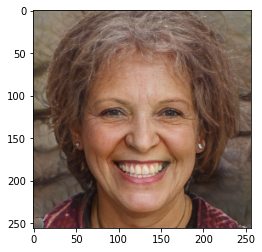

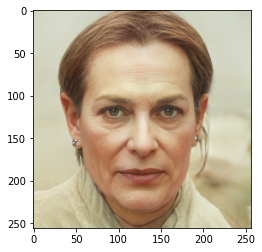

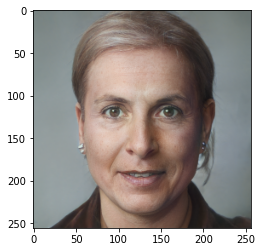

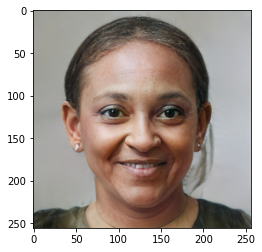

In [56]:
%matplotlib inline
for name in output_images:
    plt.figure()
    plt.imshow(name)